#### Normalizing Flow

-  Normalizing flows transform simple densities (like Gaussians) into rich complex distributions that can be used for generative models, RL, and variational inference.
- A normalizing flow describes the transformation of a probability density through a sequence of invertible mappings. By repeatedly applying the rule for change of variables, the initial density ‘flows’ through the sequence of invertible mappings. At the end of this sequence we obtain a valid probability distribution and hence this type of flow is
referred to as a normalizing flow.
- Normal Distribution’s ease-of-use makes it a very popular choice for many generative modeling and reinforcement learning algorithms. (typically, multivariate Gaussians with diagonal covariance matrices.)
- By construction, uni-modal Gaussians cannot do well on tasks that require sampling from a multi-modal distribution.

#### Change of Variables

- Let X be the distribution $\text{Uniform}(0,1)$. Let random variable $Y = f(X) = 2X+1$. (simple affine)
- On a particular $x$ and an infinitesimally nearby point $x + dx$ , then applying f to them takes us to the pair $(y, y + dy)$. 
- Because probability mass must integrate to 1, the probability (area under pdf) should be preserved while transforming to another domain. Thus, 
$$ p(x)dx = p(y)dy $$
$$p(y)=p(x)|dx/dy|$$

#### Jacobian determinant

- For non-linear mapping, the Jacobian at a certain point $x_0$, gives the best linear approximation of the non-linear trasformation. (**locally linear**)
- The determinant of transformation matrix explains the ratio of how the area(volume) expands/shrinks due to the linear transformation.
- The Jacobian determinant at a certain point thus gives the rate of the change in volume.
$$ p(y) = p(x)\left|\text{det}\frac{d\mathbf{x}}{d\mathbf{y}} \right| = p(f^{-1}(y))\left|\text{det}\frac{df^{-1}}{d\mathbf{y}} \right|$$, where $y=f(x), x=f^{-1}(y)$
$$\log p(y) = \log p(f^{-1}(y)) + \log \left|\text{det}\frac{df^{-1}}{d\mathbf{y}} \right|$$

#### Formulation of normalizing flow

$$
\begin{aligned}
\mathbf{x} = \mathbf{z}_K &= f_K \circ f_{K-1} \circ \dots \circ f_1 (\mathbf{z}_0) \\
\log p(\mathbf{x}) = \log \pi_K(\mathbf{z}_K) 
&= \log \pi_{K-1}(\mathbf{z}_{K-1}) - \log\left\vert\det\dfrac{d f_K}{d \mathbf{z}_{K-1}}\right\vert \\
&= \log \pi_{K-2}(\mathbf{z}_{K-2}) - \log\left\vert\det\dfrac{d f_{K-1}}{d\mathbf{z}_{K-2}}\right\vert - \log\left\vert\det\dfrac{d f_K}{d\mathbf{z}_{K-1}}\right\vert \\
&= \dots \\
&= \log \pi_0(\mathbf{z}_0) - \sum_{i=1}^K \log\left\vert\det\dfrac{d f_i}{d\mathbf{z}_{i-1}}\right\vert
\end{aligned}
$$

><p>The path traversed by the random variables <script type="math/tex">\mathbf{z}_i = f_i(\mathbf{z}_{i-1})</script> is the <strong>flow</strong> and the full chain formed by the successive distributions <script type="math/tex">\pi_i</script> is called a <strong>normalizing flow</strong>. Required by the computation in the equation, a transformation function <script type="math/tex">f_i</script> should satisfy two properties:</p>
><ol>
  <li>It is easily invertible.</li>
  <li>Its Jacobian determinant is easy to compute.</li>
</ol>

><p>With normalizing flows in our toolbox, the exact log-likelihood of input data <script type="math/tex">\log p(\mathbf{x})</script> becomes tractable. As a result, the training criterion of flow-based generative model is simply the negative log-likelihood (NLL) over the training dataset <script type="math/tex">\mathcal{D}</script>:</p>
>$$\mathcal{L}(\mathcal{D}) = - \frac{1}{\vert\mathcal{D}\vert}\sum_{\mathbf{x} \in \mathcal{D}} \log p(\mathbf{x})$$

#### Toy example implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
sns.set(style="whitegrid")
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
sess = tf.InteractiveSession()

In [4]:
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

(-10, 10)

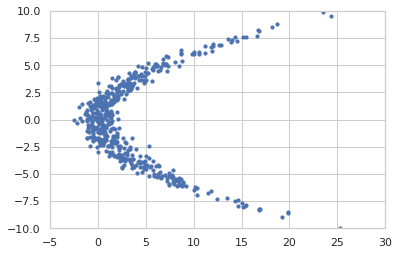

In [5]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=DTYPE))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)
np_samples = sess.run(x_samples)
plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10)
plt.xlim([-5, 30])
plt.ylim([-10, 10])

In [6]:
class PReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="p_relu"):
        super(PReLU, self).__init__(
            forward_min_event_ndims=0,
            validate_args=validate_args,
            name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        log_abs_det_J_inv = tf.log(tf.abs(J_inv))
        return log_abs_det_J_inv

In [7]:
prelu = PReLU()

In [8]:
print('1:', sess.run(prelu._forward(2.0)))
print('2:', sess.run(prelu._forward(-2.0)))
print('3:', sess.run(prelu._inverse(3.0)))
print('4:', sess.run(prelu._inverse(-3.0)))
print('5:',sess.run(prelu._inverse_log_det_jacobian(-1.0)))

W0930 07:08:58.369951 140257666029376 deprecation.py:323] From <ipython-input-6-90bf9f82fec1>:10: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1: 2.0
2: -1.0
3: 3.0
4: -6.0
5: 0.6931472


In [9]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2]))
d, r = 2, 2
bijectors = []
num_layers = 6
for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i):
        V = tf.get_variable('V', [d, r], dtype=DTYPE)
        shift = tf.get_variable('shift', [d], dtype=DTYPE)
        L = tf.get_variable('L', [d*(d+1)/2], dtype=DTYPE)
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,
        ))
        alpha = tf.abs(tf.get_variable('alpha', [], dtype=DTYPE))+.01
        bijectors.append(PReLU(alpha=alpha))

W0930 07:09:00.331641 140257666029376 deprecation.py:506] From /home/parkchanwoo/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])),
                         name='2d_mlp_bijector')
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [11]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [12]:
sess.run(tf.global_variables_initializer())

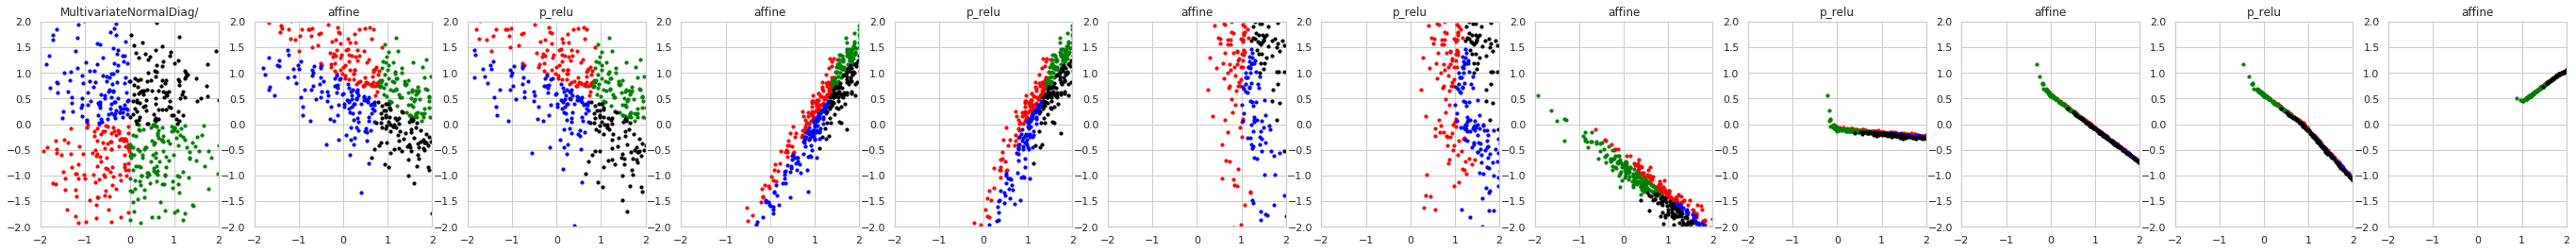

In [13]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [14]:
NUM_STEPS = int(5e4)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(5e3) == 0:
        print(i, np_loss)
start = 10

0 86059.586
5000 8.353724
10000 5.8329973
15000 5.738344
20000 5.932284
25000 5.822255
30000 5.9111257
35000 6.0253744
40000 6.0155993
45000 6.149755


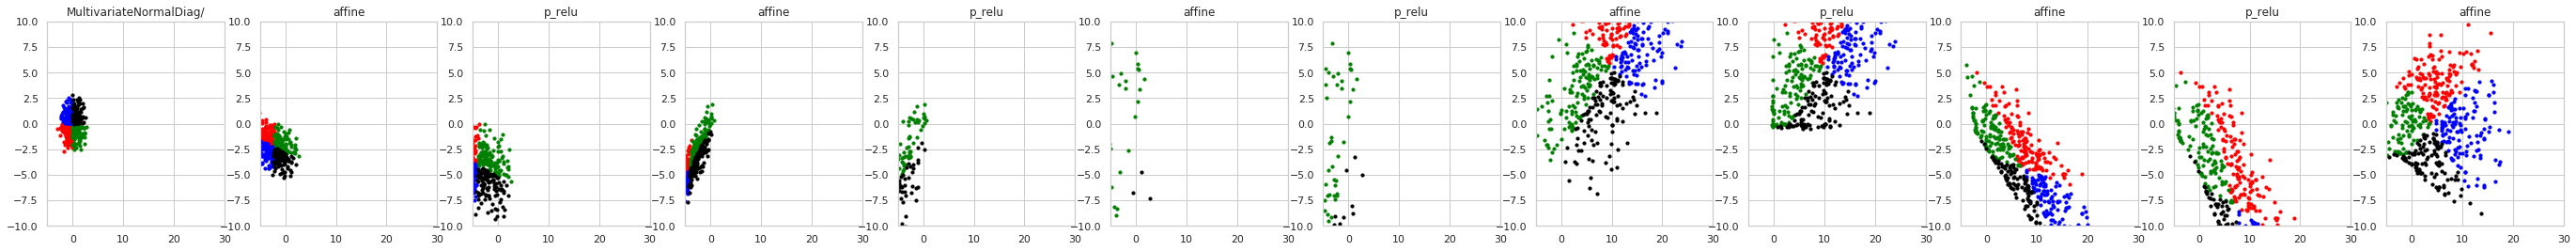

In [15]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-5, 30])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

(-10, 10)

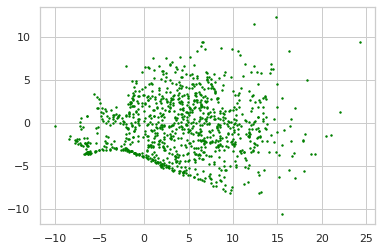

In [16]:
X1 = sess.run(dist.sample(1000))
plt.scatter(X1[:, 0], X1[:, 1], color='green', s=2)
arr[i].set_xlim([-5, 30])
arr[i].set_ylim([-10, 10])